In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import random as rn
from keras.layers import Dense
from keras import Input
from keras.engine import Model
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, \
    LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D

Using TensorFlow backend.


# Loading the Dataset

In [2]:
DATA_DIR = './free-spoken-digit-dataset-master/recordings/'

In [3]:
random_file = rn.choice(os.listdir(DATA_DIR))

# Loading the data with the default Librosa settings

In [4]:
wav, sr = librosa.load(DATA_DIR + random_file)
print ('sr:', sr)
print ('wav shape:', wav.shape)
print ('length:', wav.shape[0]/float(sr), 'secs')

sr: 22050
wav shape: (8021,)
length: 0.36376417233560093 secs


# Loading the data without the default Librosa sampling 

In [5]:
wav, sr = librosa.load(DATA_DIR + random_file, sr=None)
print ('sr:', sr)
print ('wav shape:', wav.shape)
print ('length:', wav.shape[0]/float(sr), 'secs')

sr: 8000
wav shape: (2910,)
length: 0.36375 secs


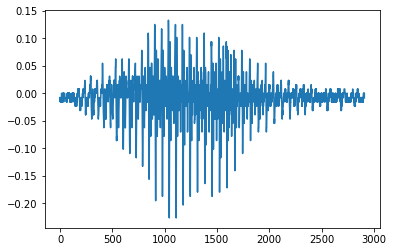

In [6]:
plt.plot(wav)

# Splitting the Data into 2 speakers for trainging and 2 for testing.

In [8]:
X = []
y = []
pad = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
for fname in os.listdir(DATA_DIR):
    struct = fname.split('_')
    digit = struct[0]
    wav, sr = librosa.load(DATA_DIR + fname)
    padded = pad(wav, 30000)
    X.append(padded)
    y.append(digit)
X = np.vstack(X)
y = np.array(y)
print ('X:', X.shape)
print ('y:', y.shape)

X: (2000, 30000)
y: (2000,)


# Preparing Test/Train Data

In [9]:
test_speaker = ['theo', 'jackson']
train_X = []
train_spectrograms = []
train_y = []

test_X = []
test_spectrograms = []
test_y = []

pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
pad2d = lambda a, i: a[:, 0: i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0],i - a.shape[1]))))

for fname in os.listdir(DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        struct = fname.split('_')
        digit = struct[0]
        speaker = struct[1]
        wav, sr = librosa.load(DATA_DIR + fname)
        padded_x = pad1d(wav, 30000)
        spectrogram = np.abs(librosa.stft(wav))
        padded_spectogram = pad2d(spectrogram,40)



        if speaker in (test_speaker):
            test_X.append(padded_x)
            test_spectrograms.append(padded_spectogram)
 
            test_y.append(digit)
        else:
            train_X.append(padded_x)
            train_spectrograms.append(padded_spectogram)
            train_y.append(digit)
    except Exception as e:
        print (fname, e)
        raise

train_X = np.vstack(train_X)
train_spectrograms = np.array(train_spectrograms)

train_y = to_categorical(np.array(train_y))

test_X = np.vstack(test_X)
test_spectrograms = np.array(test_spectrograms)

test_y = to_categorical(np.array(test_y))


print ('train_X:', train_X.shape)
print ('train_spectrograms:', train_spectrograms.shape)

print ('train_y:', train_y.shape)
print
print ('test_X:', test_X.shape)
print ('test_spectrograms:', test_spectrograms.shape)

print ('test_y:', test_y.shape)

train_X: (1000, 30000)
train_spectrograms: (1000, 1025, 40)
train_y: (1000, 10)
test_X: (1000, 30000)
test_spectrograms: (1000, 1025, 40)
test_y: (1000, 10)


# Here is the Benchmark model implementation

In [10]:
ip = Input(shape=(X[0].shape))
hidden = Dense(128, activation='relu')(ip)
op = Dense(10, activation='softmax')(hidden)
model = Model(input=ip, output=op)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3840128   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 3,841,418
Trainable params: 3,841,418
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X,
          train_y,
          epochs=10,
          batch_size=32,
          validation_data=(test_X, test_y))

Train on 1000 samples, validate on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 5s 5ms/step - loss: 2.2681 - acc: 0.1320 - val_loss: 2.3410 - val_acc: 0.1350
Epoch 2/10
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8726 - acc: 0.5080 - val_loss: 2.4365 - val_acc: 0.1430
Epoch 3/10
1000/1000 [==============================] - 5s 5ms/step - loss: 1.5841 - acc: 0.5990 - val_loss: 2.5943 - val_acc: 0.1380
Epoch 4/10
1000/1000 [==============================] - 5s 5ms/step - loss: 1.3597 - acc: 0.6840 - val_loss: 2.7886 - val_acc: 0.1230
Epoch 5/10
1000/1000 [==============================] - 5s 5ms/step - loss: 1.1891 - acc: 0.7500 - val_loss: 3.0159 - val_acc: 0.1230
Epoch 6/10
1000/1000 [==============================] - 5s 5ms/step - loss: 1.0509 - acc: 0.8000 - val_loss: 3.2598 - val_acc: 0.1270
Epoch 7/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.9348 - acc: 0.8450 - val_loss: 3.5019 - val_acc: 0.1280
Epoch 8/10
100

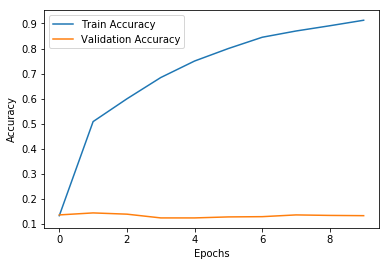

In [12]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Let's build the same Classification using CNN

In [13]:
train_X_ex = np.expand_dims(train_spectrograms, -1)
test_X_ex = np.expand_dims(test_spectrograms, -1)
print ('train X shape:', train_X_ex.shape)
print ('test X shape:', test_X_ex.shape)

train X shape: (1000, 1025, 40, 1)
test X shape: (1000, 1025, 40, 1)


In [14]:
ip = Input(shape=train_X_ex[0].shape)
m = Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same')(ip)
m = MaxPooling2D(pool_size=(4, 4))(m)
m = Dropout(0.2)(m)
m = Conv2D(64, kernel_size=(4, 4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4, 4))(m)
m = Dropout(0.2)(m)
m = Flatten()(m)
m = Dense(32, activation='relu')(m)
op = Dense(10, activation='softmax')(m)

model = Model(input=ip, output=op)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1025, 40, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1022, 37, 64)      1088      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 255, 9, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 255, 9, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 146880)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4700192   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total para

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
          train_y,
          epochs=50,
          batch_size=32,
          verbose=1,
          validation_data=(test_X_ex, test_y))

Train on 1000 samples, validate on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 123s 123ms/step - loss: 1.5232 - acc: 0.4940 - val_loss: 4.8002 - val_acc: 0.3870
Epoch 2/50
1000/1000 [==============================] - 116s 116ms/step - loss: 0.5321 - acc: 0.8270 - val_loss: 4.7461 - val_acc: 0.3440
Epoch 3/50
1000/1000 [==============================] - 118s 118ms/step - loss: 0.2788 - acc: 0.9040 - val_loss: 4.7113 - val_acc: 0.4830
Epoch 4/50
1000/1000 [==============================] - 118s 118ms/step - loss: 0.2293 - acc: 0.9340 - val_loss: 5.4879 - val_acc: 0.4120
Epoch 5/50
1000/1000 [==============================] - 120s 120ms/step - loss: 0.2242 - acc: 0.9390 - val_loss: 5.5418 - val_acc: 0.4160
Epoch 6/50
1000/1000 [==============================] - 121s 121ms/step - loss: 0.1948 - acc: 0.9410 - val_loss: 5.2385 - val_acc: 0.4570
Epoch 7/50
1000/1000 [==============================] - 119s 119ms/step - loss: 0.1168 - acc: 0.9730 - val_loss: 4.2989 - va

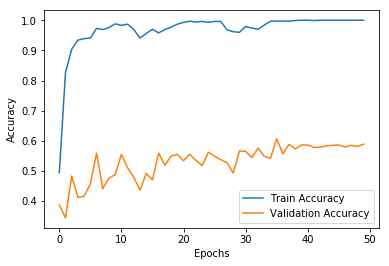

In [20]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Conclusion